In [1]:
%matplotlib inline

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import fasttext
from tok import *
from multiprocessing import Pool
import os
import tensorflow_addons as tfa

In [2]:
train_df=pd.read_csv("train_set.csv")
test_df=pd.read_csv("test_set.csv")
val_df=pd.read_csv("val_set.csv")

In [3]:
sentences=train_df.txt.to_list()

In [4]:
%%time
#multiprocessing
if __name__ ==  '__main__': 

    p=Pool(processes = os.cpu_count())
    tokens = p.map(tokenize,sentences)
    p.close()
    p.join()  # block at this line until all processes are done
    print("completed")

completed
Wall time: 27.6 s


In [5]:
tokens[0]

['citation',
 'nr',
 '<num7>',
 'decision',
 'date',
 '<date>',
 'archive',
 'date',
 '<date>',
 'docket',
 'no',
 '<num2>',
 '<num2>',
 '<num3>',
 'date']

In [6]:
tokens_all=[i for t in tokens for i in t]
voc = {v: k for k, v in dict(enumerate(set(tokens_all))).items()}

In [7]:
voc_size=len(voc)
voc_size

4912

In [8]:
#unknown words numbered asvoc_size+1
ids=[[voc_size if x not in voc else voc[x] for x in i] for i in tokens]

In [9]:
padded_sequences = pad_sequences(ids, truncating='post', maxlen=50, padding='post',value=voc_size+1) 

In [10]:
padded_sequences[3]

array([1916,  374, 1665, 1394, 2910, 3093, 2425, 1154, 1356, 4913, 4913,
       4913, 4913, 4913, 4913, 4913, 4913, 4913, 4913, 4913, 4913, 4913,
       4913, 4913, 4913, 4913, 4913, 4913, 4913, 4913, 4913, 4913, 4913,
       4913, 4913, 4913, 4913, 4913, 4913, 4913, 4913, 4913, 4913, 4913,
       4913, 4913, 4913, 4913, 4913, 4913])

In [11]:
labels = train_df["type"].to_list()

In [12]:
classes = set(labels)

classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [13]:
classes_to_index,index_to_classes

({'LegalPolicy': 0,
  'Citation': 1,
  'PolicyBasedReasoning': 2,
  'EvidenceBased/Intermediate Finding': 3,
  'Procedure': 4,
  'Header': 5,
  'EvidenceBasedReasoning': 6,
  'CaseIssue': 7,
  'ConclusionOfLaw': 8,
  'Evidence': 9,
  'RemandInstructions': 10,
  'CaseHeader': 11,
  'LegalRule': 12,
  'CaseFooter': 13},
 {0: 'LegalPolicy',
  1: 'Citation',
  2: 'PolicyBasedReasoning',
  3: 'EvidenceBased/Intermediate Finding',
  4: 'Procedure',
  5: 'Header',
  6: 'EvidenceBasedReasoning',
  7: 'CaseIssue',
  8: 'ConclusionOfLaw',
  9: 'Evidence',
  10: 'RemandInstructions',
  11: 'CaseHeader',
  12: 'LegalRule',
  13: 'CaseFooter'})

In [14]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])
train_labels = names_to_ids(labels)
print(train_labels[10])

5


In [15]:
def pad_lab(df):
    sentences_=df.txt.to_list()
    if __name__ ==  '__main__': 

        p=Pool(processes = os.cpu_count())
        tokens_ = p.map(tokenize,sentences_)
        p.close()
        p.join()
        
    ids=[[voc_size if x not in voc else voc[x] for x in i] for i in tokens_]
    padded_sequences_ = pad_sequences(ids, truncating='post', maxlen=50, padding='post',value=voc_size+1)
    labels_ = df["type"].to_list()
    labels_int = names_to_ids(labels_)
    return padded_sequences_,labels_int

In [16]:
val_sequences, val_labels = pad_lab(val_df)

In [17]:
test_sequences, test_labels = pad_lab(test_df)

In [18]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
model=fasttext.load_model("c_bow.bin")
from numpy import zeros
embedding_matrix = zeros((voc_size+2, 100))
for word, i in voc.items():
    embedding_vector = model.get_word_vector(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [19]:
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Embedding(voc_size+2, 100, weights=[embedding_matrix], input_length=50),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True, recurrent_dropout=0.25)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dense(14, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           491400    
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           160800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 200)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense (Dense)                (None, 14)                2814      
Total params: 895,814
Trainable params: 895,814
Non-trainable params: 0
__________________________________________________

In [20]:
h = model.fit(
    padded_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
    ]
)

Epoch 1/15
246/246 [==============================] - 28s 93ms/step - loss: 1.0487 - accuracy: 0.6577 - val_loss: 0.8478 - val_accuracy: 0.7374
Epoch 2/15
246/246 [==============================] - 24s 97ms/step - loss: 0.7240 - accuracy: 0.7558 - val_loss: 0.7497 - val_accuracy: 0.7573
Epoch 3/15
246/246 [==============================] - 30s 120ms/step - loss: 0.6572 - accuracy: 0.7821 - val_loss: 0.7150 - val_accuracy: 0.7890
Epoch 4/15
246/246 [==============================] - 31s 124ms/step - loss: 0.6126 - accuracy: 0.7952 - val_loss: 0.7456 - val_accuracy: 0.7773
Epoch 5/15
246/246 [==============================] - 31s 127ms/step - loss: 0.5758 - accuracy: 0.8061 - val_loss: 0.7375 - val_accuracy: 0.7796


In [21]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

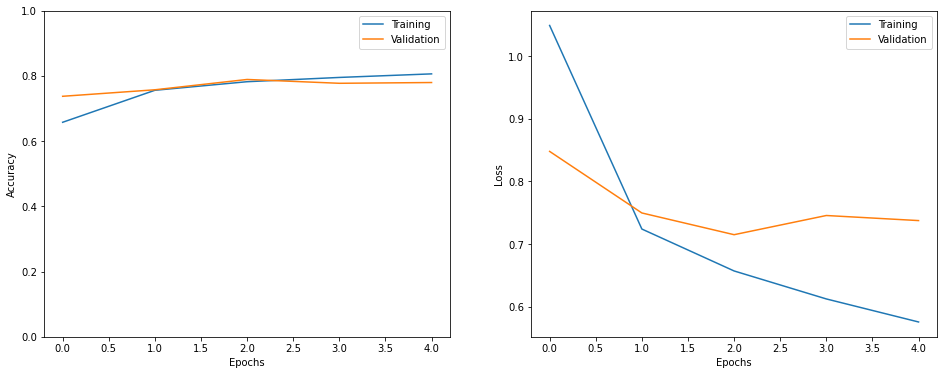

In [22]:
show_history(h)

In [23]:
eval = model.evaluate(test_sequences, test_labels)

17/17 [==============================] - 1s 38ms/step - loss: 0.5988 - accuracy: 0.8236


In [26]:
for a in range(0,5):
    i = random.randint(0, len(test_labels) - 1)

    print('Sentence:', test_df.txt.to_list()[i])
    print('Actual Type:', index_to_classes[test_labels[i]])

    p = model.predict_classes(np.expand_dims(test_sequences[i], axis=0))[0]

    print('Predicted Type:', index_to_classes.get(p), '\n')

Sentence: See Rabideau v. Derwinski, 2 Vet. App. 141, 143 (1992); Brammer v. Derwinski, 3 Vet. App. 223 (1992). 
Actual Type: Citation
Predicted Type: Citation 

Sentence: Again according to all [x-rays], the fracture is old, although a definit[]e time of injury is not applicable per [x-ray]. 
Actual Type: Evidence
Predicted Type: Evidence 

Sentence: Subsequently, the RO re-adjudicated the Veteran's claim, confirming and continuing the denial thereof. 
Actual Type: Evidence
Predicted Type: Evidence 

Sentence: Citation Nr: 1502967 Decision Date: 01/21/15 Archive Date: 01/27/15 DOCKET NO. 94-25 188 ) DATE ) )
Actual Type: CaseHeader
Predicted Type: CaseHeader 

Sentence: In this regard, the record contains multiple medical opinions which address whether the veteran has PTSD and whether it is related to service.
Actual Type: Evidence
Predicted Type: EvidenceBasedReasoning 



In [30]:
from sklearn.metrics import classification_report


In [27]:
y_pred=model.predict_classes(test_sequences)

In [41]:
y_pred_=np.vectorize(index_to_classes.get)(y_pred)
test_labels_=np.vectorize(index_to_classes.get)(test_labels)

In [48]:
print(classification_report(y_pred_,test_labels_,labels=['CaseFooter', 'CaseHeader', 'CaseIssue', 'Citation',
       'ConclusionOfLaw', 'Evidence',
       'EvidenceBased/Intermediate Finding', 'EvidenceBasedReasoning',
       'Header',  'LegalRule', 'LegalPolicy',
       'Procedure', 'RemandInstructions']))

                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00        10
                        CaseHeader       1.00      1.00      1.00         9
                         CaseIssue       1.00      1.00      1.00         9
                          Citation       1.00      0.95      0.98        64
                   ConclusionOfLaw       0.88      0.78      0.82        18
                          Evidence       0.76      0.83      0.79       109
EvidenceBased/Intermediate Finding       0.57      0.68      0.62        37
            EvidenceBasedReasoning       0.42      0.20      0.27        41
                            Header       1.00      0.99      0.99        75
                         LegalRule       0.70      0.88      0.78        34
                       LegalPolicy       0.00      0.00      0.00         2
                         Procedure       0.95      0.86      0.90        83
           